In [1]:
import statsmodels.api as sm
import yfinance as yf
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
univ = [
    "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD",
    "ADA-USD", "DOGE-USD", "SOL-USD", "MATIC-USD",
    "DOT-USD", "LTC-USD"
]
px = yf.download(univ, start = '2020-01-01', end = '2024-12-31')
prices = px['Close']
rets = prices / prices.shift() - 1
vols = px['Volume']
highs = px['High']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [545]:
def weekly_mom_signals(prices, lookback):
    # Last close of each week
    weekly_close = prices.resample('W-FRI').last()
    log_returns = np.log(weekly_close / weekly_close.shift(1))
    log_returns = log_returns.rolling(lookback, min_periods = 1).sum()
    
    # Reindex back to daily frequency
    signals = log_returns.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [546]:
def monthly_mom_signals(prices, lookback):
    # Last close of each month
    monthly_close = prices.resample('M').last()
    log_returns = np.log(monthly_close / monthly_close.shift(1))
    log_returns = log_returns.rolling(lookback, min_periods=1).sum()
    
    # Reindex back to daily frequency
    signals = log_returns.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [5]:
def weekly_hmom_signals(prices, highs, lookback):
    weekly_close = prices.resample('W-FRI').last()
    lnct = np.log(weekly_close)
    lnht = np.log(highs.rolling(lookback * 7, min_periods = 1).max())
    hmom = lnct - lnht.shift() # natural log of rolling high before this week's close
    signals = hmom.fillna(method='ffill')
    signals.fillna(0, inplace=True)
    return signals

In [530]:
def monthly_hmom_signals(prices, highs, lookback):
    monthly_close = prices.resample('M').last()
    lnct = np.log(monthly_close)
    lnht = np.log(highs.resample('M').max().rolling(lookback, min_periods=1).max())
    hmom = lnct - lnht.shift()  # natural log of rolling monthly high before this month's close

    signals = hmom.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [547]:
def weekly_mmom_signals(prices, lookback):
    weekly_close = prices.resample('W-FRI').last()
    log_close = np.log(weekly_close)
    mean_log_close = log_close.rolling(lookback, min_periods = 1).mean()
    spread = log_close - mean_log_close.shift() # z-score of log close vs. mean log close over lookback period
    signals = spread / spread.std()
    signals = signals.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [531]:
def monthly_mmom_signals(prices, lookback):
    monthly_close = prices.resample('M').last()
    log_close = np.log(monthly_close)
    mean_log_close = log_close.rolling(lookback, min_periods=1).mean()
    spread = log_close - mean_log_close.shift()
    signals = spread / spread.std()
    signals = signals.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [389]:
def weekly_market_mom_signals(prices, lookback):
    weekly_close = prices.resample('W-FRI').last()
    log_close = np.log(weekly_close)
    log_returns = np.log(weekly_close / weekly_close.shift(1))
    log_returns = log_returns.rolling(lookback, min_periods = 1).sum()
    quantiles = log_returns.T.quantile(.5)
    aligned_quantiles = quantiles.reindex(log_returns.index)
    signals = log_returns.subtract(aligned_quantiles, axis=0)
    signals = signals.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [532]:
def monthly_market_mom_signals(prices, lookback):
    monthly_close = prices.resample('M').last()
    log_close = np.log(monthly_close)
    log_returns = log_close - log_close.shift(1)
    log_returns = log_returns.rolling(lookback, min_periods=1).sum()
    
    quantiles = log_returns.T.quantile(0.5)
    aligned_quantiles = quantiles.reindex(log_returns.index)
    signals = log_returns.subtract(aligned_quantiles, axis=0)
    
    signals = signals.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [505]:
def base_mom_weights(sigs, long_q = .67, short_q = .33):
    # Generate cross sectional long biased long-short weights
    # Input: signal df
    # Output: weights df
    weights = pd.DataFrame(0, index=sigs.index, columns=sigs.columns)

    for date, row in sigs.iterrows():
        long_cut = row.quantile(long_q)
        short_cut = row.quantile(short_q)

        long_idx = row[row > long_cut].index
        short_idx = row[row < short_cut].index

        if len(long_idx) > 0:
            weights.loc[date, long_idx] = 1.3 / len(long_idx)
        if len(short_idx) > 0:
            weights.loc[date, short_idx] = -0.3 / len(short_idx)

    return weights

In [488]:
def portfolio(weights, rets):
    # Generate portfolio return based on weights and historical returns
    # Input: weights df, rets df
    # Output: portfolio return df of size (n_dates, 1)
    all_portfolio = (weights.shift() * rets).fillna(0)
    portfolio = all_portfolio.sum(1)
    return portfolio

In [489]:
def portfolio_turnover(weights):
    return np.abs(weights.shift() - weights).sum(1)

In [490]:
def port_results(weights, lookback, rets):
    port = portfolio(weights, rets)
    sharpe = port.mean() / port.std() * np.sqrt(252)
    turnover = portfolio_turnover(weights)
    tcost = 20 * 1e-4 * turnover
    tcost_port = port - tcost
    tcost_adj_sharpe = tcost_port.mean() / tcost_port.std() * np.sqrt(252)

    return pd.DataFrame([{
        'Lookback': lookback,
        'Ann. Ret': port.mean() * 252,
        'Ann. Vol': port.std() * np.sqrt(252),
        'Ann. Sharpe': sharpe,
        'Avg. Tcost BPS': tcost.mean() * 10000,
        'Ann. Ret Post Tcosts': tcost_port.mean() * 252,
        'Ann. Sharpe Post Tcosts': tcost_adj_sharpe
    }])

In [533]:
# Weekly signal functions
weekly_signal_funcs = {
    'mom': weekly_mom_signals,
    'hmom': weekly_hmom_signals,
    'mmom': weekly_mmom_signals,
    'mamom': weekly_market_mom_signals
}

# Monthly signal functions
monthly_signal_funcs = {
    'mom': monthly_mom_signals,
    'hmom': monthly_hmom_signals,
    'mmom': monthly_mmom_signals,
    'mamom': monthly_market_mom_signals
}

In [534]:
def train_results(px, highs, rets, signal_funcs):
    results_list = []
    for lookback in [1, 2, 3, 4, 8, 12, 26, 52]:
        for name, func in signal_funcs.items():
            if name == 'hmom':
                sig = func(px, highs, lookback)
            else:
                sig = func(px, lookback)
            weights = base_mom_weights(sig)
            df = port_results(weights, lookback, rets)
            df['Signal'] = name
            results_list.append(df)

    all_results_df = pd.concat(results_list, ignore_index=True)
    return all_results_df

In [535]:
training_mask = px.index < '2023-06-01'
training_px = px[training_mask]
training_highs = highs[training_mask]
training_rets = rets[training_mask]
train_results_df_weekly = train_results(training_px, training_highs, training_rets, weekly_signal_funcs)

In [493]:
idx = train_results_df_weekly.groupby('Signal')['Ann. Sharpe Post Tcosts'].idxmax()
best_lookbacks_df = train_results_df_weekly.loc[idx]
best_lookbacks_df

,Lookback,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts,Signal
17,8,1.037427,0.737592,1.406506,1.624520,0.996489,1.351075,hmom
11,3,1.593279,1.070286,1.488648,2.987770,1.517987,1.418420,mamom
10,3,1.138972,0.850261,1.339555,4.083023,1.036079,1.218090,mmom
8,3,1.464322,0.870216,1.682712,3.735271,1.370193,1.574324,mom


In [540]:
train_results_df_monthly = train_results(training_px, training_highs, training_rets, monthly_signal_funcs)

In [541]:
idx_m = train_results_df_monthly.groupby('Signal')['Ann. Sharpe Post Tcosts'].idxmax()
best_lookbacks_monthly = train_results_df_monthly.loc[idx_m]
best_lookbacks_monthly

,Lookback,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts,Signal
5,2,0.815150,0.780343,1.044606,0.568046,0.800835,1.026390,hmom
3,1,1.069575,0.950837,1.124878,1.385160,1.034669,1.088285,mamom
2,1,0.603639,0.847948,0.711882,1.318175,0.570421,0.672649,mmom
0,1,0.987293,0.951070,1.038086,1.397613,0.952073,1.001156,mom


In [542]:
def test_results(px, highs, rets, best_lookbacks_df, signal_funcs):
    results_list = []
    all_weights = {}

    for _, row in best_lookbacks_df.iterrows():
        signal_name = row['Signal']
        lookback = row['Lookback']

        func = signal_funcs[signal_name]

        if signal_name == 'hmom':
            sig = func(px, highs, lookback)
        else:
            sig = func(px, lookback)
        weights = base_mom_weights(sig)
        perf = port_results(weights, lookback, rets)
        perf['Signal'] = signal_name
        perf['Lookback'] = lookback
        all_weights.update({signal_name: weights})
        results_list.append(perf)

    test_results_df = pd.concat(results_list, ignore_index=True)
    return test_results_df, all_weights

In [515]:
test_mask = px.index >= '2023-06-01'
test_px = px[test_mask]
test_highs = highs[test_mask]
test_rets = rets[test_mask]
test_results_df = test_results(test_px, test_highs, test_rets, best_lookbacks_df, weekly_signal_funcs)[0]

In [550]:
test_results_df.round(2)

,Lookback,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts,Signal
0,8,0.76,0.46,1.67,1.59,0.72,1.58,hmom
1,3,1.03,0.69,1.50,3.08,0.95,1.38,mamom
2,3,0.91,0.55,1.63,4.09,0.80,1.45,mmom
3,3,0.91,0.57,1.60,3.82,0.82,1.43,mom


In [543]:
test_results_monthly = test_results(test_px, test_highs, test_rets, best_lookbacks_monthly, monthly_signal_funcs)[0]

In [551]:
test_results_monthly.round(2)

,Lookback,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts,Signal
0,2,0.69,0.50,1.36,0.49,0.67,1.34,hmom
1,1,0.66,0.54,1.23,1.29,0.63,1.16,mamom
2,1,0.68,0.51,1.32,1.33,0.64,1.25,mmom
3,1,0.66,0.54,1.23,1.29,0.63,1.16,mom


In [517]:
all_weights = test_results(test_px, test_highs, test_rets, best_lookbacks_df)[1]

In [522]:
btc_ret = test_rets['BTC-USD']
all_ports = {}

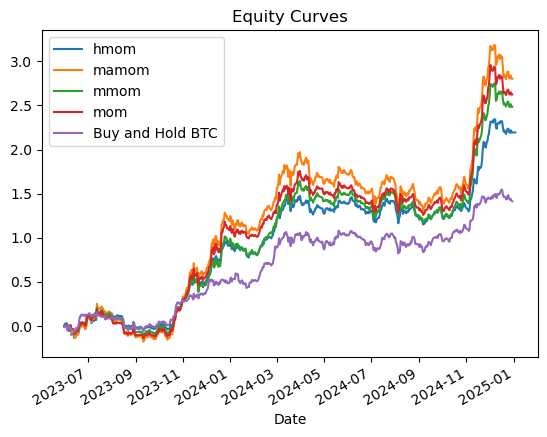

In [523]:
for name, weights in all_weights.items():
    port = (weights * test_rets).sum(1)
    all_ports.update({name: port})
    port.cumsum().plot(label=name)
plt.title('Equity Curves')
btc_ret.cumsum().plot(label='Buy and Hold BTC')
plt.legend()

In [524]:
all_results = {}
ann_alphas = {}
X = sm.add_constant(pd.Series(rets['BTC-USD'], name='Buy & Hold Coins'))

for name, port in all_ports.items():
    y = pd.Series(port, name=name)
    X, y = X.fillna(0), y.fillna(0)
    X, y = X.align(y, join='inner', axis=0)
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params[1]

    results_dict = {
        'alpha': alpha,
        'beta': beta,
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'alpha_pval': model.pvalues['const'],
        'beta_pval': model.pvalues[1],
        'alpha_tval': model.tvalues['const'],
        'beta_tval': model.tvalues[1],
        'std_err_alpha': model.bse['const'],
        'std_err_beta': model.bse[1],
        'n_obs': int(model.nobs),
        'f_statistic': model.fvalue,
        'f_pvalue': model.f_pvalue
    }
    ann_alphas[name] = alpha * 252
    all_results[name] = results_dict

test_stats = pd.DataFrame(all_results).T.round(4)
test_stats

,alpha,beta,r_squared,adj_r_squared,alpha_pval,beta_pval,alpha_tval,beta_tval,std_err_alpha,std_err_beta,n_obs,f_statistic,f_pvalue
hmom,0.0015,0.9264,0.6283,0.6276,0.0453,0.0,2.0061,31.2277,0.0008,0.0297,579.0,975.1709,0.0
mamom,0.0016,1.3159,0.5748,0.5741,0.1789,0.0,1.3459,27.9283,0.0012,0.0471,579.0,779.9873,0.0
mmom,0.0018,1.0216,0.5388,0.5380,0.0757,0.0,1.7797,25.9632,0.0010,0.0393,579.0,674.0896,0.0
mom,0.0020,1.0382,0.5093,0.5084,0.0671,0.0,1.8348,24.4701,0.0011,0.0424,579.0,598.7859,0.0
